#Data loading

In [126]:
!pip install opendatasets --upgrade --quiet

In [127]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


In [128]:
# Download the dataset
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [129]:
raw_df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0           W           44.0          W        WNW          20.0   
1         WNW           44.0        NNW        WSW           4.0   
2         WSW           46.0          W        WSW          19.0   
3          NE           24.0         SE          E          11.0   
4           W           41.0        ENE         NW           7.0   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0          24.0         71.0         22.0       1007.7       1007.1       8.0   
1          22.0         44.0         25.0       1010.6       1007.8       NaN   
2          26.0         38.0         30.0       1007.6       1008.7       NaN   
3           9.0         45.0         16.0       1017.6       1012.8       NaN   
4          20.0         82.0         33.0       1010.8       1006.0       7.0   

   Cloud3pm  Temp9am  Temp3pm RainToday RainTomorrow  
0       NaN     16.9     21.8        No           No  
1       NaN     17.2     24.3        No           No  
2       2.0     21.0     23.2        No           No  
3       NaN     18.1     26.5        No           No  
4       8.0     17.8     29.7        No           No

In [130]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140787 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           140787 non-null  object 
 1   Location       140787 non-null  object 
 2   MinTemp        140319 non-null  float64
 3   MaxTemp        140480 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81093 non-null   float64
 6   Sunshine       73982 non-null   float64
 7   WindGustDir    131624 non-null  object 
 8   WindGustSpeed  131682 non-null  float64
 9   WindDir9am     131127 non-null  object 
 10  WindDir3pm     137117 non-null  object 
 11  WindSpeed9am   139732 non-null  float64
 12  WindSpeed3pm   138256 non-null  float64
 13  Humidity9am    139270 non-null  float64
 14  Humidity3pm    137286 non-null  float64
 15  Pressure9am    127044 non-null  float64
 16  Pressure3pm    127018 non-null  float64
 17  Cloud9am       88162 non-null   fl

#Data Visualization

In [131]:
#Importing libraries
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#setup plotting parameters
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [132]:

px.histogram(raw_df, x='Location', title='Location vs. Rainy Days', color='RainToday')

Insight:

*  We have mostly uniform distribution of data across locations.
*  Seems to be roughly the cases that about 20% of days in pretty much every city there was rain.
*   And then for about 80 or 75% of days, there was no rain.
*   There is some correlation between Location and Rain.


In [133]:

px.histogram(raw_df,
             x='Temp3pm',
             title='Temperature at 3 pm vs. Rain Tomorrow',
             color='RainTomorrow')

Insight:


*  The red indicates the cases where it did rain tomorrow and blue indicates no rain.
*  So, if the temperature at 3pm is lower, it's more,it seems likely that it would rain tomorrow.

*  Although, there are still a decent number of examples where 3pm temperature has been high and it has still rained tomorrow.

In [134]:
px.histogram(raw_df,
             x='RainTomorrow',
             color='RainToday',
             title='Rain Tomorrow vs. Rain Today')

Insight:


*   The proportion of rain tomorrow is very low as compared to no rain .
*   If it did not rain today, then there's a pretty good chance that it will not rain tomorrow,so predicting rain tomorrow 'Yes' is difficult and predicting rain tomorrow 'No' is easier
*   And there is class imbalance.






In [135]:
px.scatter(raw_df.sample(2000),
           title='Min Temp. vs Max Temp.',
           x='MinTemp',
           y='MaxTemp',
           color='RainToday')

Insight:


*  There is a linear correlation between MinTemp & MaxTemp.
*  When it rains on a particular day, then the variation in temperature is small.
*  And maybe that is also relevant for whether it rains tomorrow or not.





In [136]:
px.scatter(raw_df.sample(2000),
           title='Temp (3 pm) vs. Humidity (3 pm)',
           x='Temp3pm',
           y='Humidity3pm',
           color='RainTomorrow')

Insight:


* All the red points are in the low temperature and high humidity region,
And blue points are in the high temperature and low humidity region.

*  If the temperature today's low and humidity is high, then there's a high chance that there maybe rain tomorrow.



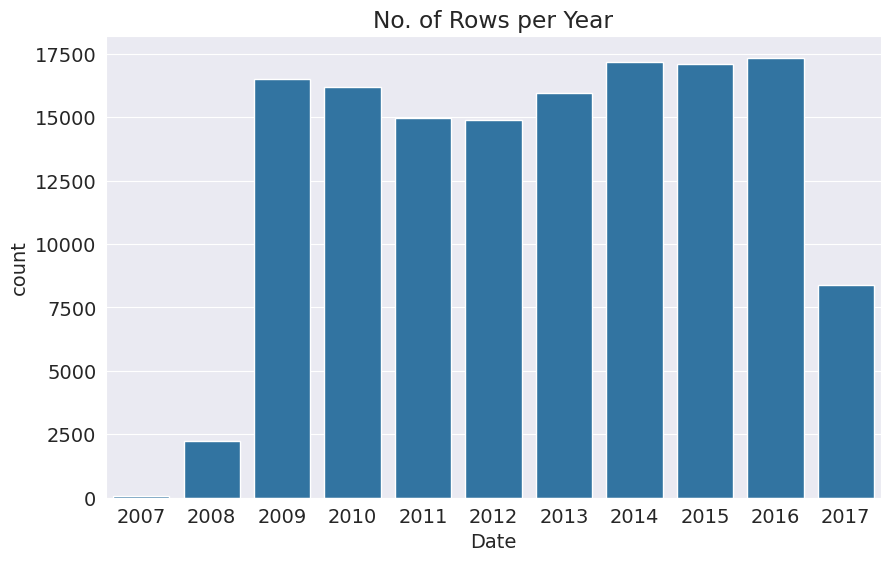

In [137]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

Insight:


*   Mostly, there's normal distribution of data in years.
*   Most of the data are lies between 2009 - 2016.



#Data Preprocessing

In [138]:
# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [139]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (97988, 23)
val_df.shape : (17089, 23)
test_df.shape : (25710, 23)


Identifying Input and Target Columns
Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the Date column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

# Create inputs and targets

In [140]:
# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [141]:
print(input_cols)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [142]:
target_col

'RainTomorrow'

In [143]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [144]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [145]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's also identify which of the columns are numerical and which ones are categorical. This will be useful later, as we'll need to convert the categorical data to numbers for training a logistic regression model.

# Identify numeric and categorical columns

In [146]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

Do the ranges of the numeric columns seem reasonable? If not, we may have to do some data cleaning as well.

Imputing Missing Numeric Data
Machine learning models can't work with missing numerical data. The process of filling missing values is called imputation.

The first step in imputation is to `fit` the imputer to the data i.e. compute the chosen statistic (e.g. mean) for each column in the dataset.

In [147]:
imputer = SimpleImputer(strategy = 'mean')

In [148]:
imputer.fit(raw_df[numeric_cols])

SimpleImputer()

After calling `fit`, the computed statistic for each column is stored in the `statistics_` property of `imputer`.

In [149]:
list(imputer.statistics_)

[12.18482386562048,
 23.235120301822324,
 2.349974074310839,
 5.472515506887154,
 7.630539861047281,
 39.97051988882308,
 13.990496092519967,
 18.631140782316862,
 68.82683277087672,
 51.44928834695453,
 1017.6545771543717,
 1015.2579625879797,
 4.431160817585808,
 4.499250233195188,
 16.98706638787991,
 21.69318269001107]

The missing values in the training, test and validation sets can now be filled in using the `transform` method of `imputer`.

In [150]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

The missing values are now filled in with the mean of each column.

Scaling Numeric Features
Another good practice is to scale numeric features to a small range of values e.g.
(
0
,
1
)
(0,1) or
(
−
1
,
1
)
(−1,1). Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.

Let's use `MinMaxScaler` from `sklearn.preprocessing` to scale values to the $(0,1)$ range.

In [151]:
scaler = MinMaxScaler()

In [152]:
scaler.fit(raw_df[numeric_cols])

MinMaxScaler()

We can now inspect the minimum and maximum values in each column.

In [153]:
print('Minimum:')
list(scaler.data_min_)

Minimum:


[-8.5,
 -4.8,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 980.5,
 977.1,
 0.0,
 0.0,
 -7.2,
 -5.4]

In [154]:
print('Maximum:')
list(scaler.data_max_)

Maximum:


[33.9,
 48.1,
 371.0,
 145.0,
 14.5,
 135.0,
 130.0,
 87.0,
 100.0,
 100.0,
 1041.0,
 1039.6,
 9.0,
 9.0,
 40.2,
 46.7]

We can now separately scale the training, validation and test sets using the `transform` method of `scaler`.

In [155]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

Encoding Categorical Data
Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

In [156]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [157]:
encoder.fit(raw_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [158]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

The encoder has created a list of categories for each of the categorical columns in the dataset.

We can generate column names for each individual category using `get_feature_names_out
`.

In [159]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

All of the above columns will be added to `train_inputs`, `val_inputs` and `test_inputs`.

To perform the encoding, we use the `transform` method of `encoder`.

In [160]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

<ipython-input-160-8950d7c1751d>:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-160-8950d7c1751d>:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-160-8950d7c1751d>:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-160-8950d7c1751d>:1: PerformanceWarning:

In [161]:
# To set an No limit in displaying columns
pd.set_option('display.max_columns', None)

In [162]:
test_inputs

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
2498     Albury  0.681604  0.801512  0.000000     0.037741  0.526244   
2499     Albury  0.693396  0.725898  0.001078     0.037741  0.526244   
2500     Albury  0.634434  0.527410  0.005930     0.037741  0.526244   
2501     Albury  0.608491  0.538752  0.042049     0.037741  0.526244   
2502     Albury  0.566038  0.523629  0.018329     0.037741  0.526244   
...         ...       ...       ...       ...          ...       ...   
145454    Uluru  0.283019  0.502836  0.000000     0.037741  0.526244   
145455    Uluru  0.266509  0.533081  0.000000     0.037741  0.526244   
145456    Uluru  0.285377  0.568998  0.000000     0.037741  0.526244   
145457    Uluru  0.327830  0.599244  0.000000     0.037741  0.526244   
145458    Uluru  0.384434  0.601134  0.000000     0.037741  0.526244   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
2498           ENE       0.372093        NaN        ESE      0.000000   
2499           SSE       0.341085        SSE         SE      0.069231   
2500           ENE       0.325581        ESE        ENE      0.084615   
2501           SSE       0.255814         SE        SSE      0.069231   
2502           ENE       0.193798         SE        SSE      0.046154   
...            ...            ...        ...        ...           ...   
145454           E       0.193798        ESE          E      0.115385   
145455           E       0.193798         SE        ENE      0.100000   
145456         NNW       0.124031         SE          N      0.100000   
145457           N       0.240310         SE        WNW      0.069231   
145458          SE       0.170543        SSE          N      0.100000   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
2498        0.080460         0.46         0.17     0.543802       0.5136   
2499        0.195402         0.54         0.30     0.505785       0.5008   
2500        0.448276         0.62         0.67     0.553719       0.6032   
2501        0.195402         0.74         0.65     0.618182       0.6304   
2502        0.103448         0.92         0.63     0.591736       0.5888   
...              ...          ...          ...          ...          ...   
145454      0.149425         0.59         0.27     0.730579       0.7056   
145455      0.126437         0.51         0.24     0.728926       0.6912   
145456      0.103448         0.56         0.21     0.710744       0.6720   
145457      0.103448         0.53         0.24     0.669421       0.6352   
145458      0.080460         0.51         0.24     0.642975       0.6304   

        Cloud9am  Cloud3pm   Temp9am   Temp3pm RainToday  Location_Adelaide  \
2498    0.777778  0.333333  0.702532  0.808061        No                0.0   
2499    0.888889  0.888889  0.675105  0.712092        No                0.0   
2500    0.888889  0.888889  0.611814  0.477927       Yes                0.0   
2501    0.888889  0.888889  0.556962  0.518234       Yes                0.0   
2502    0.888889  0.888889  0.514768  0.529750       Yes                0.0   
...          ...       ...       ...       ...       ...                ...   
145454  0.492351  0.499917  0.350211  0.504798        No                0.0   
145455  0.492351  0.499917  0.364979  0.533589        No                0.0   
145456  0.492351  0.499917  0.381857  0.573896        No                0.0   
145457  0.492351  0.499917  0.415612  0.604607        No                0.0   
145458  0.333333  0.222222  0.470464  0.602687        No                0.0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
2498                0.0              1.0                    0.0   
2499                0.0              1.0                    0.0   
2500                0.0              1.0                    0.0   
2501                0.0              1.0                    0.0   
2502                0.0              1.0                    0.0   
.

# Save processed data to disk

In [163]:
!pip install pyarrow --quiet

In [164]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')

In [165]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

CPU times: user 59 ms, sys: 0 ns, total: 59 ms
Wall time: 67.4 ms


We can read the data back using `pd.read_parquet`.

In [166]:
%%time

train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

CPU times: user 299 ms, sys: 191 ms, total: 490 ms
Wall time: 429 ms


Let's verify that the data was loaded properly.

In [167]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (97988, 123)
train_targets: (97988,)
val_inputs: (17089, 123)
val_targets: (17089,)
test_inputs: (25710, 123)
test_targets: (25710,)


# Model Training and Evaluation

Training a Logistic Regression Model
Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model:

In [168]:
# Import the LogisticRegression model
from sklearn.linear_model import LogisticRegression

In [169]:
# Create and train the model
model = LogisticRegression(solver='liblinear')

We can train the model using `model.fit`.

In [170]:
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

LogisticRegression(solver='liblinear')

In [171]:
#To show the features and their weights & intercept
print(numeric_cols + encoded_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_

In [172]:
print(model.coef_.tolist())

[[0.8986324151652026, -2.8799288484272725, 3.1627783941533836, 0.854233199097419, -1.6713967645743446, 6.764401997617562, -0.9423193916231418, -1.4284332004350349, 0.32288705993860534, 5.995309618290915, 5.463842155596162, -9.17680276828724, -0.16230118601099724, 1.2876575875289866, 0.4747071394851873, 2.021436091461751, 0.6016503155225178, -0.5524816082098337, 0.4781437731763531, 0.007665268046942364, 0.34681451580237477, -0.35227817340007966, 0.179711399916397, 0.44048778217353635, -0.01398114695470229, 0.02894542200290951, 0.25814954936639495, -0.02120462546599252, -0.042796507118596186, -0.4831421250609206, -0.13756199126704258, -0.5760603459151452, -0.7875267102260608, -0.2554043193119793, -0.32888557652985945, -0.5690061685416732, 0.08183012548576335, 0.01337885424500912, 0.06412739003123773, -0.902055123317936, -0.44432923536376756, 0.008522707040877443, -0.46061421444037337, -0.46551869427571413, -0.06950053405236756, 0.19116044505301996, 0.45047653558120854, 0.6081202596542495

In [173]:
print(model.intercept_)

[-2.44956109]


We can create a DataFrame of features and their weights, then we can conclude the top features, those have more impact on target column

Each weight is applied to the value in a specific column of the input. Higher the weight, greater the impact of the column on the prediction.

In [174]:
n = len(model.coef_.tolist())

weight_df=pd.DataFrame({
    'feature': numeric_cols + encoded_cols,
    'weight': model.coef_.tolist()[0]
})

<Axes: xlabel='weight', ylabel='feature'>

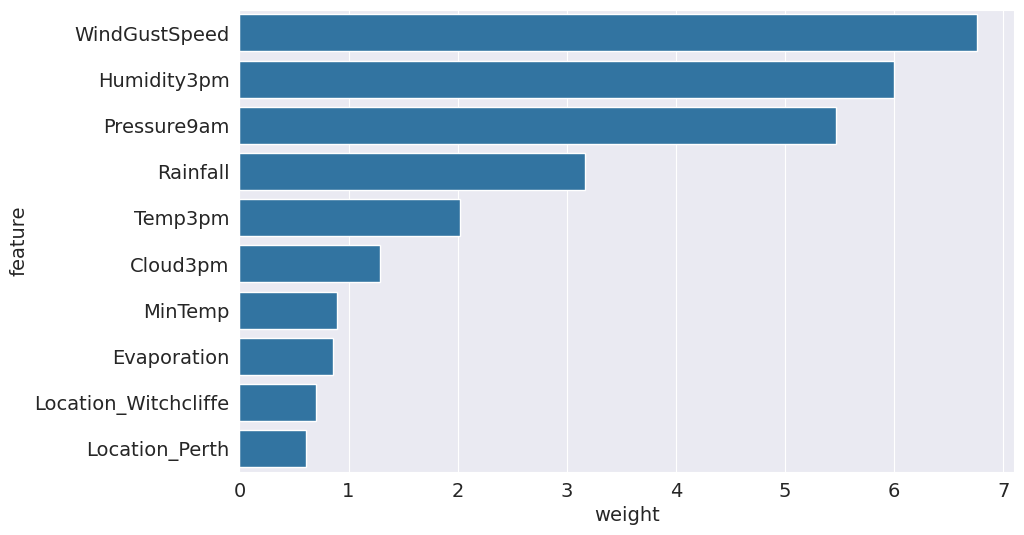

In [175]:
# Visualize the features with their weights
import seaborn as sns
sns.barplot(data=weight_df.sort_values('weight',ascending=False).head(10),x='weight',y='feature')

Making Predictions and Evaluating the Model
We can now use the trained model to make predictions on the training, test

In [176]:
# Select the columns to be used for training/prediction
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

 Generate predictions and probabilities

In [177]:
train_preds = model.predict(X_train)

We can output a probabilistic prediction using `predict_proba`.

In [178]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.94401311, 0.05598689],
       [0.94074304, 0.05925696],
       [0.96093735, 0.03906265],
       ...,
       [0.98749147, 0.01250853],
       [0.98334725, 0.01665275],
       [0.87453712, 0.12546288]])

The numbers above indicate the probabilities for the target classes "No" and "Yes".

In [179]:
model.classes_

array(['No', 'Yes'], dtype=object)

We can test the accuracy of the model's predictions by computing the percentage of matching values in `train_preds` and `train_targets`.

This can be done using the `accuracy_score` function from `sklearn.metrics`.

In [180]:
#Importing the classification_report and accuracy metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [181]:
print(classification_report(train_targets, train_preds))

              precision    recall  f1-score   support

          No       0.87      0.95      0.91     76190
         Yes       0.74      0.52      0.61     21798

    accuracy                           0.85     97988
   macro avg       0.80      0.73      0.76     97988
weighted avg       0.84      0.85      0.84     97988



The model achieves an accuracy of 85.1% on the training set. We can visualize the breakdown of correctly and incorrectly classified inputs using a confusion matrix.

<img src="https://i.imgur.com/UM28BCN.png" width="480">

Depending on the business usecases or what you want to use the model for,you may want to very closely look at false positives or false negatives.for example, if you use this model to predict whether a baseball game should be hosted tomorrow in the open, then false negatives are a big problem.
you may want to avoid false negatives where it is going to rain tomorrow, but your model predicts that is  not going to rain, so if you have a high number of false negatives,that means you are in for a surprise where you get a 50,000 people and people are playing baseball and starts rain.
That's why you maybe want you to optimize. you want to reduce the false negatives and you are  not just interested in accuracy.

On the other hand,let's say it's a different kind of model,which is predicting whether you may have breast cancer. Then at that point, you may want to take a closer look at False Positive,before let's say recommending, I don't know , chemotherapy to somebody, you want to make sure that your model,you want to make sure that it is not a false positive and for that while training the model,you want to make sure that the number of false positive low

So in general,depending on the kind of problem you may want to optimize either for False positives,all for false negatives

In [182]:
#Importing confusion metrics
from sklearn.metrics import confusion_matrix

In [183]:
confusion_matrix(train_targets, train_preds, normalize='true')

array([[0.94621341, 0.05378659],
       [0.4776585 , 0.5223415 ]])

So based on the confusion matrix,if the model says that it's not going to rain tomorrow, I'm probably not that sure,because there is still 47% chances that the model says that is not going to rain tomorrow

Let's define a helper function to generate predictions, compute the accuracy score and plot a confusion matrix for a given st of inputs.

In [184]:
def predict_and_plot(inputs,targets, name=''):
  preds = model.predict(inputs)

  accuracy = accuracy_score(targets,preds)
  print('Accuracy: {:2f}%'.format(accuracy * 100))

  cf = confusion_matrix(targets, preds, normalize='true')
  plt.figure()
  sns.heatmap(cf, annot = True)
  plt.xlabel('Prediction')
  plt.ylabel('Target')
  plt.title('{} Confusion_Matrix'.format(name));

  return preds

Evaluate on train set

Accuracy: 85.192064%


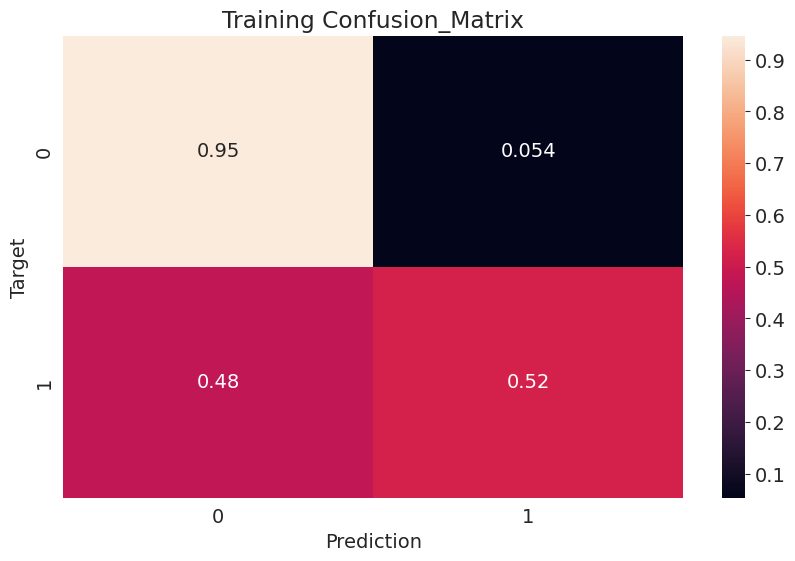

In [185]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Let's compute the model's accuracy on the validation and test sets too.

Accuracy: 85.399965%


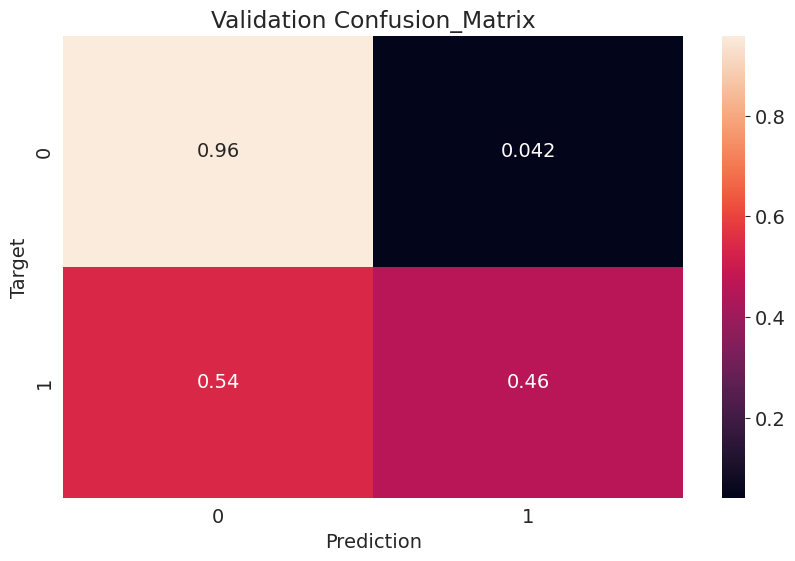

In [186]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

Accuracy: 84.200700%


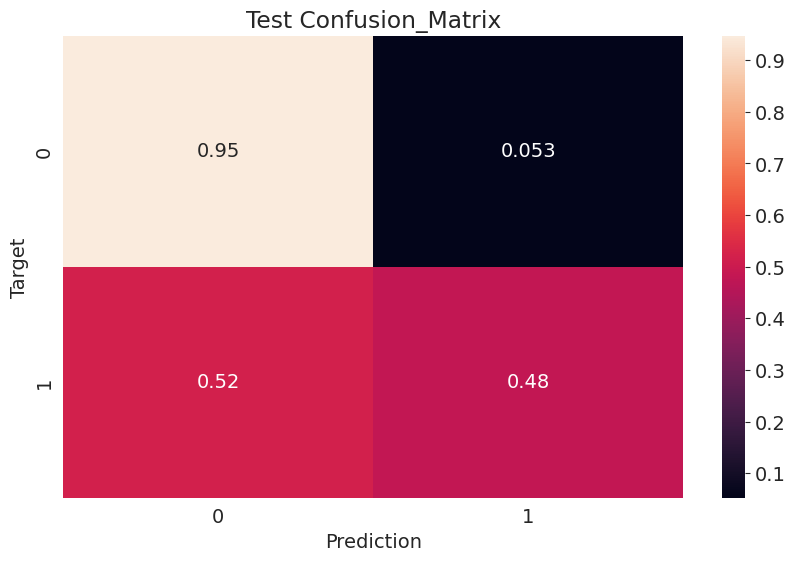

In [187]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

The accuracy of the model on the test and validation set are above 84%, which suggests that our model generalizes well to data it hasn't seen before.

But how good is 84% accuracy? While this depends on the nature of the problem and on business requirements, a good way to verify whether a model has actually learned something useful is to compare its results to a "random" or "dumb" model.

Let's create two models: one that guesses randomly and another that always return "No". Both of these models completely ignore the inputs given to them.

In [188]:
def random_guess(inputs):
  return np.random.choice(['No','Yes'],len(inputs))

In [189]:
def all_no(inputs):
  return np.full(len(inputs),'No')

Let's check the accuracies of these two models on the test set.

In [190]:
accuracy_score(test_targets, random_guess(X_test))

0.49509918319719953

In [191]:
accuracy_score(test_targets, all_no(X_test))

0.7734344612991054

Our random model achieves an accuracy of 50% and our "always No" model achieves an accuracy of 77%.

Thankfully, our model is better than a "dumb" or "random" model! This is not always the case, so it's a good practice to benchmark any model you train against such baseline models.

## Making Predictions on a Single Input

Once the model has been trained to a satisfactory accuracy, it can be used to make predictions on new data. Consider the following dictionary containing data collected from the Katherine weather department today.

In [192]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 15.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

The first step is to convert the dictionary into a Pandas dataframe, similar to `raw_df`. This can be done by passing a list containing the given dictionary to the `pd.DataFrame` constructor.

In [193]:
new_input_df = pd.DataFrame([new_input])
new_input_df

Date   Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2021-06-19  Katherine     23.2     33.2      10.2          4.2       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0         NNW           15.0         NW        NNE          13.0   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0          20.0         89.0         58.0       1004.8       1001.5       8.0   

   Cloud3pm  Temp9am  Temp3pm RainToday  
0       5.0     25.7     33.0       Yes

We must now apply the same transformations applied while training the model:

Imputation of missing values using the imputer created earlier.

Scaling numerical features using the scaler created earlier.

Encoding categorical features using the encoder created earlier.

In [194]:

new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

<ipython-input-194-1e64a48fb6dc>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-194-1e64a48fb6dc>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-194-1e64a48fb6dc>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-194-1e64a48fb6dc>:3: PerformanceWarning:

In [195]:

X_new_input = new_input_df[numeric_cols + encoded_cols]
X_new_input

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0  0.747642  0.718336  0.027493     0.028966  0.526244       0.069767   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0           0.1      0.229885         0.89         0.58     0.401653   

   Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  Location_Adelaide  \
0       0.3904  0.888889  0.555556  0.694093  0.737044                0.0   

   Location_Albany  Location_Albury  Location_AliceSprings  \
0              0.0              0.0                    0.0   

   Location_BadgerysCreek  Location_Ballarat  Location_Bendigo  \
0                     0.0                0.0               0.0   

   Location_Brisbane  Location_Cairns  Location_Canberra  Location_Cobar  \
0                0.0              0.0                0.0             0.0   

   Location_CoffsHarbour  Location_Dartmoor  Location_Darwin  \
0                    0.0                0.0              0.0   

   Location_GoldCoast  Location_Hobart  Location_Katherine  \
0                 0.0              0.0                 1.0   

   Location_Launceston  Location_Melbourne  Location_MelbourneAirport  \
0                  0.0                 0.0                        0.0   

   Location_Mildura  Location_Moree  Location_MountGambier  \
0               0.0             0.0                    0.0   

   Location_MountGinini  Location_Newcastle  Location_Nhil  \
0                   0.0                 0.0            0.0   

   Location_NorahHead  Location_NorfolkIsland  Location_Nuriootpa  \
0                 0.0                     0.0                 0.0   

   Location_PearceRAAF  Location_Penrith  Location_Perth  \
0                  0.0               0.0             0.0   

   Location_PerthAirport  Location_Portland  Location_Richmond  Location_Sale  \
0                    0.0                0.0                0.0            0.0   

   Location_SalmonGums  Location_Sydney  Location_SydneyAirport  \
0                  0.0              0.0                     0.0   

   Location_Townsville  Location_Tuggeranong  Location_Uluru  \
0                  0.0                   0.0             0.0   

   Location_WaggaWagga  Location_Walpole  Location_Watsonia  \
0                  0.0               0.0                0.0   

   Location_Williamtown  Location_Witchcliffe  Location_Wollongong  \
0                   0.0                   0.0                  0.0   

   Location_Woomera  WindGustDir_E  WindGustDir_ENE  WindGustDir_ESE  \
0               0.0            0.0              0.0              0.0   

   WindGustDir_N  WindGustDir_NE  WindGustDir_NNE  WindGustDir_NNW  \
0            0.0             0.0              0.0              1.0   

   WindGustDir_NW  WindGustDir_S  WindGustDir_SE  WindGustDir_SSE  \
0             0.0            0.0             0.0              0.0   

   WindGustDir_SSW  WindGustDir_SW  WindGustDir_W  WindGustDir_WNW  \
0              0.0             0.0            0.0              0.0   

   WindGustDir_WSW  WindGustDir_nan  WindDir9am_E  WindDir9am_ENE  \
0              0.0              0.0           0.0             0.0   

   WindDir9am_ESE  WindDir9am_N  WindDir9am_NE  WindDir9am_NNE  \
0             0.0           0.0            0.0             0.0   

   WindDir9am_NNW  WindDir9am_NW  WindDir9am_S  WindDir9am_SE  WindDir9am_SSE  \
0             0.0            1.0           0.0            0.0             0.0   

   WindDir9am_SSW  WindDir9am_SW  WindDir9am_W  WindDir9am_WNW  \
0             0.0            0.0           0.0             0.0   

   WindDir9am_WSW  WindDir9am_nan  WindDir3pm_E  WindDir3pm_ENE  \
0             0.0             0.0           0.0             0.0   

   WindDir3pm_ESE  WindDir3pm_N  WindDir3pm_NE  WindDir3pm_NNE  \
0             0.0           0.0            0.0             1.0   

   WindDir3pm_NNW  WindDir3pm_NW  WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  \
0             0.0            0.0           0.0           

We can now make a prediction using model.predict.


In [196]:
prediction = model.predict(X_new_input)[0]

In [197]:
prediction

'No'

Our model predicts that it will rain tomorrow in Katherine! We can also check the probability of the prediction.

In [198]:
prob = model.predict_proba(X_new_input)[0]

In [199]:
prob

array([0.86579574, 0.13420426])

## Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk.

In [200]:
import joblib

In [201]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

We can now save this to a file using `joblib.dump`

In [202]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

The object can be loaded back using `joblib.load`

In [203]:
aussie_rain2 = joblib.load('aussie_rain.joblib')

Let's use the loaded model to make predictions on the original test set.

In [204]:
test_preds2 = aussie_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

0.8420070011668611

As expected, we get the same result as the original model.